### 정수 인코딩(Integer Encoding)

- 단어 토큰화 또는 형태소 토큰화를 수행했다면 각 단어에 고유한 정수부여
- 중복이 혀용되지 않는 모든 단어 집합 생성
- 이를 단어 집합이라 하며 이를 기반으로 문서를 정수로 인코딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import torch
import urllib.request
from tqdm import tqdm
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

In [7]:
df=pd.read_csv("IMDB Dataset.csv")

In [8]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


<Axes: xlabel='sentiment'>

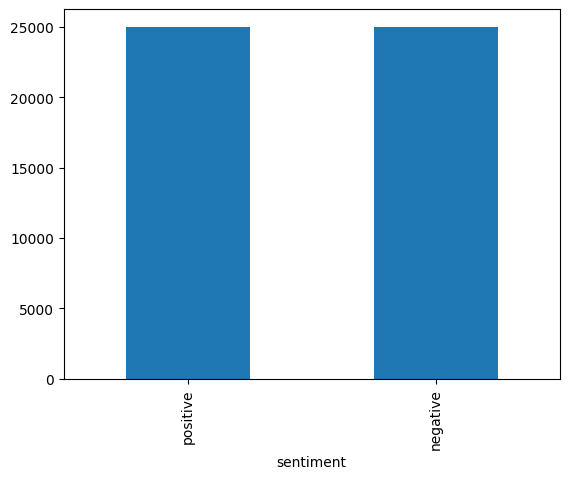

In [10]:
df['sentiment'].value_counts().plot(kind='bar')

#### 이진 물류같은 경우 레이블을 1,0으로 변경한다

In [12]:
df['sentiment']=df['sentiment'].replace(['negative','positive'],[0, 1])

### 훈련데이터와 테스트 데이터로 분류한다
- test_size를 통하여 비율 산정
- stratify에 레이블에 해당하는 데이터를 부여하면 훈련 데이터,테스트 데이터를 나눌 때 레이블의 비율을 균일하게 나누어 준다

In [13]:
X_data=df['review']
y_data=df['sentiment']
X_train,X_test,y_train,y_test=train_test_split(X_data,y_data,test_size=0.5,random_state=0,stratify=y_data)

X_train[0]

#### 토큰화 처리

In [16]:
sample=word_tokenize(X_train[0])
print(sample)

['One', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', '1', 'Oz', 'episode', 'you', "'ll", 'be', 'hooked', '.', 'They', 'are', 'right', ',', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'me.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'The', 'first', 'thing', 'that', 'struck', 'me', 'about', 'Oz', 'was', 'its', 'brutality', 'and', 'unflinching', 'scenes', 'of', 'violence', ',', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'GO', '.', 'Trust', 'me', ',', 'this', 'is', 'not', 'a', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'timid', '.', 'This', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', ',', 'sex', 'or', 'violence', '.', 'Its', 'is', 'hardcore', ',', 'in', 'the', 'classic', 'use', 'of', 'the', 'word.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'It', 'is', 'called', 'OZ', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'Oswald', 'Maximum', 'Security', 'State', 'Penitentary', '.', 

In [18]:
lower_sample=[word.lower() for word in sample] #소문지화 전처리

#### 데이터 토큰화

In [19]:
def tokenize(sentences):
    tokenized_sentences=[]
    for sentence in tqdm(sentences):
        tokenized_sent=word_tokenize(sentence)
        tokenized_sent=[word.lower() for word in tokenized_sent]
        tokenized_sentences.append(tokenized_sent)
    return tokenized_sentences

In [20]:
tokenized_X_train=tokenize(X_train)
tokenized_X_test=tokenize(X_test)


100%|██████████| 25000/25000 [00:15<00:00, 1631.48it/s]


In [21]:
for sent in tokenized_X_train[:2]:
    print(sent)

['life', 'is', 'too', 'short', 'to', 'waste', 'on', 'two', 'hours', 'of', 'hollywood', 'nonsense', 'like', 'this', ',', 'unless', 'you', "'re", 'a', 'clueless', 'naiive', '16', 'year', 'old', 'girl', 'with', 'no', 'sense', 'of', 'reality', 'and', 'nothing', 'better', 'to', 'do', '.', 'dull', 'characters', ',', 'poor', 'acting', '(', 'artificial', 'emotion', ')', ',', 'weak', 'story', ',', 'slow', 'pace', ',', 'and', 'most', 'important', 'to', 'this', 'films', 'flawed', 'existence-no', 'one', 'cares', 'about', 'the', 'overly', 'dramatic', 'relationship', '.']
['for', 'those', 'who', 'expect', 'documentaries', 'to', 'be', 'objective', 'creatures', ',', 'let', 'me', 'give', 'you', 'a', 'little', 'lesson', 'in', 'american', 'film-making.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'documentaries', 'rely', 'heavily', 'on', 'casting', '.', 'you', 'pick', 'and', 'choose', 'characters', 'you', 'think', 'will', 'enhance', 'the', 'drama', 'and', 'entertainment', 'value', 'of', 'your', 'film.', '

#### 정수 인코딩을 위하여 **vocabulary** 를 만들어야한다
- 훈련데이터의 모든 단어들을 모은다
- 이를 위해 파이썬에 있는 카운터 묘듈사용
- 입력으로 들어온 단어들의 빈도수를 체크

In [22]:
word_list=[]
for sent in tokenized_X_train:
    for word in sent:
        word_list.append(word)
word_counts=Counter(word_list)
print('총 단어수 ',len(word_counts))

총 단어수  112946


In [23]:
print(word_counts)

Counter({'the': 332140, ',': 271720, '.': 234036, 'and': 161143, 'a': 161005, 'of': 144426, 'to': 133327, 'is': 107917, '/': 100449, '>': 100324, '<': 100220, 'br': 100168, 'it': 94327, 'in': 92249, 'i': 86574, 'this': 74636, 'that': 71463, "'s": 60982, 'was': 49717, 'as': 46045, 'with': 43565, 'for': 43220, 'movie': 42174, 'but': 41604, 'film': 38621, ')': 35447, '(': 34661, 'you': 34352, 'on': 33299, "n't": 32917, "''": 32808, '``': 32316, 'not': 31021, 'are': 29947, 'he': 28740, 'his': 28579, 'have': 28337, 'be': 26416, 'one': 25891, '!': 25010, 'at': 23409, 'they': 22893, 'all': 22868, 'by': 22083, 'an': 21402, 'who': 20858, 'from': 20215, 'so': 19909, 'like': 19676, 'there': 18493, 'or': 17725, 'just': 17384, 'do': 17309, 'her': 17142, 'if': 16996, 'about': 16970, 'has': 16934, 'out': 16421, '?': 16332, 'what': 15882, 'some': 15501, 'when': 14152, 'good': 14128, 'more': 13914, 'very': 13691, 'she': 13553, 'would': 13214, 'up': 12265, 'my': 12252, 'even': 12242, 'no': 12213, 'can':

In [24]:
print('훈련데이터에서 단어 the의 등장횟수:',word_counts['the'])

훈련데이터에서 단어 the의 등장횟수: 332140


- 등장빈도수에 맞추어 정렬

In [25]:
vocab=sorted(word_counts,key=word_counts.get,reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[0:10])

등장 빈도수 상위 10개 단어
['the', ',', '.', 'and', 'a', 'of', 'to', 'is', '/', '>']
